In [8]:
import numpy as np
import torch
import torchvision
from glob import glob
import os
from datetime import datetime

import src.wnet as wnet

device = 'cuda'

In [9]:
# Construct Dataset
class BSDS500_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        self.image_paths = glob(os.path.join(root_dir, 'BSDS500', 'data', 'images', subset, '*.jpg'))
        self.image_sizes = [np.take(torchvision.io.read_image(img_path).shape, [1,2]) for img_path in self.image_paths]
        self.image_size = (224, 224)
        
        self.max_image = None
        self.min_image = None
        for i in range(self.__len__()):
            image = torchvision.io.read_image(self.image_paths[i]).float()
            image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            self.max_image = torch.max(self.max_image, image) if self.max_image is not None else image
            self.min_image = torch.min(self.min_image, image) if self.min_image is not None else image

    def __len__(self):
        return len(self.image_paths)

    def size(self, idx=None):
        s = [self.__len__(), 3, self.image_size[0], self.image_size[1]]
        if idx is not None:
            s = s[idx]
        else:
            s = torch.Size(s)
        return s

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = torchvision.io.read_image(img_path)
        image = image.float()
        image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
        image = (image - self.min_image) / (self.max_image - self.min_image)
        return image.to(device)

class BSDS500():
    def __init__(self, root_dir, batch_size):
        self.trainset = BSDS500_dataset(root_dir, 'train')
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.valset = BSDS500_dataset(root_dir, 'val')
        self.valloader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=False)
        self.testset = BSDS500_dataset(root_dir, 'test')
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size, shuffle=False)

    def get_trainloader(self):
        return self.trainloader
    
    def get_valloader(self):
        return self.valloader

    def get_testloader(self):
        return self.testloader


class PascalVOC_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        with open(os.path.join(root_dir, 'VOC2012', 'ImageSets', 'Segmentation', subset + '.txt'), 'r') as f:
            self.image_names = f.read().split("\n")
        self.image_paths = [os.path.join(root_dir, 'VOC2012', 'JPEGImages', image_name + '.jpg') for image_name in self.image_names if image_name != '']
        self.image_sizes = [np.take(torchvision.io.read_image(img_path).shape, [1,2]) for img_path in self.image_paths]
        self.image_size = (224, 224)
        self.max_image = None
        self.min_image = None
        for i in range(self.__len__()):
            image = torchvision.io.read_image(self.image_paths[i]).float()
            image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            self.max_image = torch.max(self.max_image, image) if self.max_image is not None else image
            self.min_image = torch.min(self.min_image, image) if self.min_image is not None else image

    def __len__(self):
        return len(self.image_paths)

    def size(self, idx=None):
        s = [self.__len__(), 3, self.image_size[0], self.image_size[1]]
        if idx is not None:
            s = s[idx]
        else:
            s = torch.Size(s)
        return s

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = torchvision.io.read_image(img_path)
        image = image.float()
        image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
        image = (image - self.min_image) / (self.max_image - self.min_image)
        return image.to(device)

class PascalVOC():
    def __init__(self, root_dir, batch_size):
        self.trainset = PascalVOC_dataset(root_dir, 'train')
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.valset = PascalVOC_dataset(root_dir, 'val')
        self.valloader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=False)

    def get_trainloader(self):
        return self.trainloader
    
    def get_valloader(self):
        return self.valloader

if device == "mps":
    batch_size = 16
else:
    batch_size = 8

pascal = PascalVOC('../VOCdevkit', batch_size)
X_train = pascal.get_trainloader()
y_train = pascal.get_trainloader()
X_val = pascal.get_valloader()
y_val = pascal.get_valloader()
bsds = BSDS500('../BSDS500', batch_size)
X_test = bsds.get_testloader()
y_test = bsds.get_testloader()

  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.02it/s]


EPOCH:      1
Train loss: 1.7385E-01
Valid loss: 1.5708E-01


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      2
Train loss: 9.8881E-02
Valid loss: 6.9409E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      3
Train loss: 4.3670E-02
Valid loss: 2.9462E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.88it/s]


EPOCH:      4
Train loss: 3.0132E-02
Valid loss: 3.0645E-02


  VAL: 100%|██████████| 182/182 [01:06<00:00,  2.75it/s]


EPOCH:      5
Train loss: 2.6654E-02
Valid loss: 2.5772E-02


  VAL: 100%|██████████| 182/182 [01:06<00:00,  2.74it/s]


EPOCH:      6
Train loss: 2.4448E-02
Valid loss: 2.2754E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.85it/s]


EPOCH:      7
Train loss: 2.1275E-02
Valid loss: 2.1062E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.89it/s]


EPOCH:      8
Train loss: 1.8547E-02
Valid loss: 1.6771E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.88it/s]


EPOCH:      9
Train loss: 1.8933E-02
Valid loss: 1.8305E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.91it/s]


EPOCH:      10
Train loss: 1.7378E-02
Valid loss: 2.0028E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.94it/s]


EPOCH:      11
Train loss: 1.6613E-02
Valid loss: 1.5853E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      12
Train loss: 1.6134E-02
Valid loss: 1.8034E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.96it/s]


EPOCH:      13
Train loss: 1.4625E-02
Valid loss: 1.5682E-02


  VAL: 100%|██████████| 182/182 [01:05<00:00,  2.76it/s]


EPOCH:      14
Train loss: 1.5924E-02
Valid loss: 1.4704E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      15
Train loss: 1.4275E-02
Valid loss: 1.5023E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.96it/s]


EPOCH:      16
Train loss: 1.5740E-02
Valid loss: 1.3780E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.94it/s]


EPOCH:      17
Train loss: 1.4072E-02
Valid loss: 1.2738E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      18
Train loss: 1.3704E-02
Valid loss: 1.4189E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.92it/s]


EPOCH:      19
Train loss: 1.2795E-02
Valid loss: 1.3122E-02


  VAL: 100%|██████████| 182/182 [01:04<00:00,  2.82it/s]


EPOCH:      20
Train loss: 1.3819E-02
Valid loss: 1.2236E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.85it/s]


EPOCH:      21
Train loss: 1.2865E-02
Valid loss: 1.3193E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.88it/s]


EPOCH:      22
Train loss: 1.3148E-02
Valid loss: 1.2847E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.87it/s]


EPOCH:      23
Train loss: 1.2812E-02
Valid loss: 1.1883E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      24
Train loss: 1.2694E-02
Valid loss: 1.4161E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      25
Train loss: 1.2415E-02
Valid loss: 1.3146E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      26
Train loss: 1.1836E-02
Valid loss: 1.2739E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      27
Train loss: 1.1835E-02
Valid loss: 1.1147E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      28
Train loss: 1.1793E-02
Valid loss: 1.1062E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      29
Train loss: 1.1455E-02
Valid loss: 1.1149E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.94it/s]


EPOCH:      30
Train loss: 1.1229E-02
Valid loss: 1.0270E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.94it/s]


EPOCH:      31
Train loss: 1.0739E-02
Valid loss: 1.0588E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      32
Train loss: 1.1619E-02
Valid loss: 1.1368E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.94it/s]


EPOCH:      33
Train loss: 1.1126E-02
Valid loss: 1.1888E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      34
Train loss: 1.0902E-02
Valid loss: 1.1751E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.90it/s]


EPOCH:      35
Train loss: 1.0693E-02
Valid loss: 1.0322E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.91it/s]


EPOCH:      36
Train loss: 1.0423E-02
Valid loss: 1.1229E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.92it/s]


EPOCH:      37
Train loss: 1.1088E-02
Valid loss: 1.0031E-02


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.85it/s]


EPOCH:      38
Train loss: 1.0915E-02
Valid loss: 1.0344E-02


  VAL: 100%|██████████| 182/182 [01:04<00:00,  2.82it/s]


EPOCH:      39
Train loss: 1.1215E-02
Valid loss: 9.5634E-03


  VAL: 100%|██████████| 182/182 [01:03<00:00,  2.87it/s]


EPOCH:      40
Train loss: 9.7443E-03
Valid loss: 9.5045E-03


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.90it/s]


EPOCH:      41
Train loss: 9.6243E-03
Valid loss: 1.0544E-02


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      42
Train loss: 1.0485E-02
Valid loss: 9.3574E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.95it/s]


EPOCH:      43
Train loss: 9.6056E-03
Valid loss: 9.5762E-03


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.93it/s]


EPOCH:      44
Train loss: 9.8299E-03
Valid loss: 9.4591E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      45
Train loss: 9.5569E-03
Valid loss: 1.0192E-02


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.96it/s]


EPOCH:      46
Train loss: 9.5901E-03
Valid loss: 9.2126E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.00it/s]


EPOCH:      47
Train loss: 1.0663E-02
Valid loss: 9.1426E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.96it/s]


EPOCH:      48
Train loss: 9.8076E-03
Valid loss: 8.6903E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.03it/s]


EPOCH:      49
Train loss: 9.9038E-03
Valid loss: 9.4334E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  2.99it/s]


EPOCH:      50
Train loss: 9.2062E-03
Valid loss: 9.3837E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.97it/s]


EPOCH:      51
Train loss: 8.9909E-03
Valid loss: 8.4353E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.00it/s]


EPOCH:      52
Train loss: 9.0470E-03
Valid loss: 8.7779E-03


  VAL: 100%|██████████| 182/182 [01:02<00:00,  2.89it/s]


EPOCH:      53
Train loss: 9.1103E-03
Valid loss: 8.8317E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      54
Train loss: 8.8810E-03
Valid loss: 8.6742E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.98it/s]


EPOCH:      55
Train loss: 8.8256E-03
Valid loss: 8.6871E-03


  VAL: 100%|██████████| 182/182 [01:01<00:00,  2.97it/s]


EPOCH:      56
Train loss: 8.7319E-03
Valid loss: 8.9481E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.08it/s]


EPOCH:      57
Train loss: 9.1459E-03
Valid loss: 1.0980E-02


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      58
Train loss: 8.5255E-03
Valid loss: 8.7959E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.08it/s]


EPOCH:      59
Train loss: 8.7561E-03
Valid loss: 8.8083E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.10it/s]


EPOCH:      60
Train loss: 8.9054E-03
Valid loss: 8.0202E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      61
Train loss: 8.3053E-03
Valid loss: 7.9740E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.06it/s]


EPOCH:      62
Train loss: 8.4752E-03
Valid loss: 8.3483E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


EPOCH:      63
Train loss: 8.0807E-03
Valid loss: 7.6555E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.03it/s]


EPOCH:      64
Train loss: 8.4975E-03
Valid loss: 8.6368E-03


  VAL: 100%|██████████| 182/182 [01:00<00:00,  3.02it/s]


EPOCH:      65
Train loss: 8.2965E-03
Valid loss: 8.4104E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


EPOCH:      66
Train loss: 8.1722E-03
Valid loss: 7.7861E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      67
Train loss: 7.7098E-03
Valid loss: 7.5304E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      68
Train loss: 8.0858E-03
Valid loss: 7.8376E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      69
Train loss: 7.9028E-03
Valid loss: 7.7433E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      70
Train loss: 8.3991E-03
Valid loss: 7.6261E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      71
Train loss: 7.8949E-03
Valid loss: 9.4297E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


EPOCH:      72
Train loss: 7.9076E-03
Valid loss: 8.5851E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.05it/s]


EPOCH:      73
Train loss: 7.7825E-03
Valid loss: 7.3916E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


EPOCH:      74
Train loss: 8.1762E-03
Valid loss: 8.1670E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      75
Train loss: 8.0354E-03
Valid loss: 7.4766E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.10it/s]


EPOCH:      76
Train loss: 8.2347E-03
Valid loss: 7.7368E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      77
Train loss: 7.4534E-03
Valid loss: 7.0471E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.09it/s]


EPOCH:      78
Train loss: 7.6980E-03
Valid loss: 7.3342E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      79
Train loss: 7.9936E-03
Valid loss: 7.8759E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      80
Train loss: 7.7772E-03
Valid loss: 8.9532E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.05it/s]


EPOCH:      81
Train loss: 8.0282E-03
Valid loss: 8.3368E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


EPOCH:      82
Train loss: 7.7739E-03
Valid loss: 7.6103E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      83
Train loss: 7.4698E-03
Valid loss: 7.8357E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      84
Train loss: 7.3119E-03
Valid loss: 7.5478E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      85
Train loss: 7.7407E-03
Valid loss: 7.7505E-03


  VAL: 100%|██████████| 182/182 [00:57<00:00,  3.15it/s]


EPOCH:      86
Train loss: 7.3850E-03
Valid loss: 7.3979E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      87
Train loss: 7.8091E-03
Valid loss: 7.6357E-03


  VAL: 100%|██████████| 182/182 [00:57<00:00,  3.14it/s]


EPOCH:      88
Train loss: 7.6293E-03
Valid loss: 7.3114E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      89
Train loss: 7.4931E-03
Valid loss: 6.9192E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      90
Train loss: 7.4611E-03
Valid loss: 7.8734E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.08it/s]


EPOCH:      91
Train loss: 8.1540E-03
Valid loss: 1.0936E-02


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      92
Train loss: 8.7042E-03
Valid loss: 7.8590E-03


  VAL: 100%|██████████| 182/182 [00:59<00:00,  3.07it/s]


EPOCH:      93
Train loss: 7.3712E-03
Valid loss: 7.1439E-03


  VAL: 100%|██████████| 182/182 [00:57<00:00,  3.15it/s]


EPOCH:      94
Train loss: 7.4522E-03
Valid loss: 7.3649E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      95
Train loss: 7.3341E-03
Valid loss: 7.0196E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.13it/s]


EPOCH:      96
Train loss: 7.1159E-03
Valid loss: 6.9623E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.14it/s]


EPOCH:      97
Train loss: 7.0953E-03
Valid loss: 6.9296E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


EPOCH:      98
Train loss: 7.0241E-03
Valid loss: 7.1062E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.14it/s]


EPOCH:      99
Train loss: 7.1334E-03
Valid loss: 7.2079E-03


  VAL: 100%|██████████| 182/182 [00:58<00:00,  3.10it/s]

EPOCH:      100
Train loss: 7.7286E-03
Valid loss: 7.3669E-03


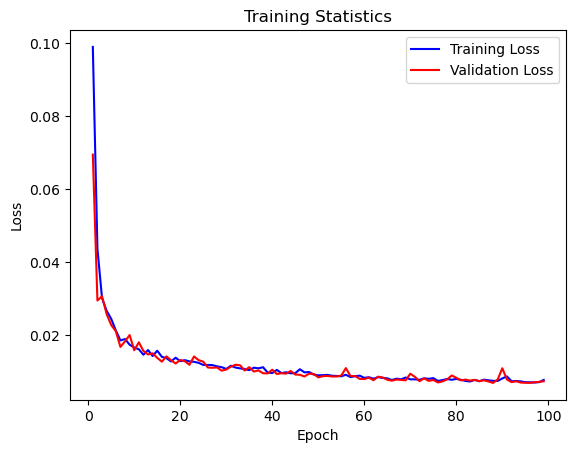

In [10]:
from importlib import reload
import src.wnet as wnet
import src.network as network
import src.loss as loss
loss = reload(loss)
network = reload(network)
wnet = reload(wnet)

train = True
epochs = 100
use_checkpoint = False
checkpoint_path = 'models/wnet-2022-12-02-02-50.pt'

net = wnet.WNet(device_type=device)
net.to(device)
if use_checkpoint:
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    print('Loaded checkpoint from {}'.format(checkpoint_path))

if train:
    net.fit(
        X_train, y_train,
        X_val, y_val,
        epochs=epochs,
        learn_rate=1e-3,
        weight_decay=1e-5
    )
    date = datetime.now().__str__()
    date = date[:16].replace(':', '-').replace(' ', '-')
    torch.save({
                'epoch': epochs,
                'model_state_dict': net.state_dict(),
                }, f'models/wnet-{date}.pt')

In [4]:
import utils.visualize as visualize
from src.crf import crf_fit_predict, crf_batch_fit_predict
import tqdm

all_inputs = []
all_masks = []
all_network_masks = []
for i,batch in tqdm.tqdm(enumerate(X_test)):
  inputs = batch
  mask, outputs = net.forward(inputs)
  inputs = inputs.detach().cpu().numpy()
  outputs = outputs.detach().cpu().numpy()
  mask = mask.detach().cpu().numpy()
  crf_mask = crf_batch_fit_predict(mask, inputs)
  for j in range(inputs.shape[0]):
    all_inputs.append(inputs[j])
    all_network_masks.append(mask[j])
    all_masks.append(crf_mask[j])
    
all_masks = np.array(all_masks)
all_inputs = np.array(all_inputs)
all_network_masks = np.array(all_inputs)

25it [08:02, 19.30s/it]


In [5]:
import skimage
import matplotlib.pyplot as plt

# Convert segmentation mask to RGB with colors averaged from the image
def mask_to_rgb(mask, image):
    mask = mask.argmax(0)
    image = image.transpose(1,2,0)
    mask_rgb = np.zeros(image.shape)
    for i in range(0, mask.max()):
        mask_rgb[mask==i] = image[mask==i].mean(0)
    return mask_rgb

# edge detection using sobel filter
def sobel_edge_detection(image):
    image = skimage.color.rgb2gray(image)
    edges = skimage.filters.sobel(image)
    return edges

# segmentation mask to csv
def mask_to_csv(mask):
    mask = mask.argmax(0)
    print(mask)

In [6]:
for i in range(all_masks.shape[0]):
    mask = mask_to_rgb(all_masks[i], all_inputs[i])
    mask = torch.from_numpy(mask).permute(2,0,1)
    id = dataset.testset.image_paths[i].split("/")[-1].split(".")[0]
    mask = torchvision.transforms.functional.resize(mask, list(dataset.testset.image_sizes[i]), interpolation=torchvision.transforms.functional.InterpolationMode.NEAREST)
    torchvision.utils.save_image(mask, f'outputs/png/{id}.png')
    
    # mask = mask_to_rgb(all_masks[i], all_inputs[i])
    mask = (skimage.color.rgb2gray(mask.permute(1,2,0)) * 255).round()
    colors = np.unique(mask)
    for i,color in enumerate(colors):
        mask[mask==color] = i
    np.savetxt(f'outputs/csv/{id}.csv', mask, delimiter=',', fmt='%i')

/tmp/ipykernel_12573/2182552978.py:10: RuntimeWarning: Mean of empty slice.
  mask_rgb[mask==i] = image[mask==i].mean(0)
/home/remote/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [7]:
from evaluation import calculate_mIOU

average_mIOU, max_mIOU = calculate_mIOU("../BSDS500/gt", "outputs/csv")
print("Average (averaged over gt segmentations) mIOU: ", average_mIOU)
print("Max (over gt segmentations) mIOU: ", max_mIOU)

100%|██████████| 200/200 [01:18<00:00,  2.55it/s]

Average (averaged over gt segmentations) mIOU:  0.11433732975607845
Max (over gt segmentations) mIOU:  0.2720017964656836
